# CL Bach: Using Machine Learning to Compose New Bach Chorales 

#### Can we reproduce the genius of Bach using machine learning?
-------------------------------------

### Summary

I am using machine learning to learn patterns in compositions by Bach. The question is, can a machine learn the basic rules of composition and counterpoint without being fed the rules explicitly? Will it learn the rules simply by observing the patterns?

#### Why Bach?
I am focusing on Bach chorales because they:

- have sufficient complexity in that they are four parts that occur at the same time
- each part only sings one note at a time (they are meant to be sung)
- each piece is fairly short and sweet - the kinds of harmonic paths are not long, sweeping expositions, but instead, compact and dense. Hopefully because the musical information is dense, I can extract valuable information more easily.
- Bach's musical lines do not get extremely complex, at least compared to later composers. What I mean by this is that Bach is often what is studied when music students learn composition 101 or counterpoint 101 - the basic underpinnings of composition. There are certain composition rules that are, for the most part, adhered to by Bach. Composers from later eras take that set of composition rules and expand them by adding much complexity. 
- the pieces are fairly similar and the Bach "footprint" is immediately evident - you can always recognize a Bach chorale once you've heard enough. Bach's composition style does not vary signficantly, so the hope is that the model continues to learn the "same" pattern over and over again.

In [2]:
import music21 as m21

import pandas as pd
import numpy as np

import copy
import cPickle

## Create the Bach Chorale dataset

Music21 is a fantastic python library that allows users to work with music data to create and analyze music compositions. It supports use of many different music formats which allows both the importing of music data to be used in composition and analysis as well as the exporting of music data in sheet music format.

It also happens to come with a large "corpus" - a set of music that has already been pre-uploaded into the Music21 system. 

Here I am accessing those files.

In [3]:
bach_composer_search = m21.corpus.getComposer('bach')
list(bach_composer_search)

[u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv1.6.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv10.7.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv101.7.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv102.7.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv103.6.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv104.6.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv108.6.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv11.6.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv110.7.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv111.6.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/music21/corpus/bach/bwv112.5-sc.mxl',
 u'//anaconda/envs/dsi/lib/python2.7/site-packages/musi

## Create the bach dictionary schema and populate scores

For purposes of identification, all Bach pieces are given an identifier with the format 'BWV XXX' where XXX is a 3 digit number. This identifier is widely used in music history.  After doing a bunch of research, I found that a large number, possibly most, of Bach's chorales were concentrated between numbers 251 and 438.

I knew I needed to manipulate each composition's score and to track information about each composition. I chose to use a dictionary to do this and it worked very well. Each composition is a dictionary key. The values for each composition are a nested dictionary with its keys being: the original score, the first manipulated score, the second manipulated score, and the original key, among others.

In [4]:
# create a dictionary of all of the bach chorales streams

# bach_dict = {
#     'bwv254' : {
#         'score': 'scoreobject',
#         'score_1' : 'scoreobject', # make all notes have same duration
#         'score_2' : 'scoreobject', # make score be in the same key
#         'orig_key': the original key,    
#       },
# }

def create_bach_dict():
    bach_dict = {}

    # make go from 251 to 438, the BWVs designated as chorales as per wikipedia research
    for bwv_no in range(253, 439): 

        # these the three scores that are not found in the corpus
        if bwv_no in [274, 275, 409]:
            pass
        else:
            try:
                score_key = 'bwv' + str(bwv_no)
                score_path = 'bach/' + score_key + '.mxl'

                # create an empty dictionary first with keys = the bwv name
                bach_dict[score_key] = {}
                bach_dict[score_key]['score'] = m21.corpus.parse(score_path)

            # print out exceptions so I can research them individually
            except:
                print "could not find this score: bwv" + str(bwv_no)

    return bach_dict

bach_dict = create_bach_dict()

could not find this score: bwv267
could not find this score: bwv388


In [5]:

# go through the exceptions

def add_addl_scores_to_dict(bwv_no_list):
    for bwv_no in bwv_no_list:
        bach_dict[bwv_no] = {}
        bach_dict[bwv_no]['score'] = m21.corpus.parse('bach/'+bwv_no+'.xml')



# could not find this score: bwv267
# added    
# could not find this score: bwv274
    # it is not in corpus
# could not find this score: bwv275
    # it is not in corpus
# could not find this score: bwv388
    # added
# could not find this score: bwv409
    # it is not in corpus

In [6]:
add_addl_scores_to_dict(['bwv267','bwv388'])

![](../../capstone/presentation/yay_gifs/tinafey1.gif)
### OK, I've got my beginning bach_dict! Tina Fey thinks I'm awesome.


## Create score1: turn a score into one where all notes have the same duration.

To feed music data into a model, I need to make sure that all the notes I'm feeding in are occurring for the same time t.  You'll see in the score below (showcasing how awesome music21 is at showing music inline or separately) that the notes all have different durations. If I were to put the notes into a model right now, they would not line up with the rest of the notes occurring at the same time.  Since the choice of a note depends heavily on what the other notes are doing at the same time, it was necessary to get all the notes into the model for the same time t.

To do this, I decided to take the lowest common note duration and turn all notes into multiples of 16h notes. (There was one score with 32nd notes, so I dealt with those separately.)  That way, any time I fed in music notes into the model, I would be guaranteed that the next set of notes in the sequence for each part (soprano, alto, tenor, bass) would line up and occur at the same time t.

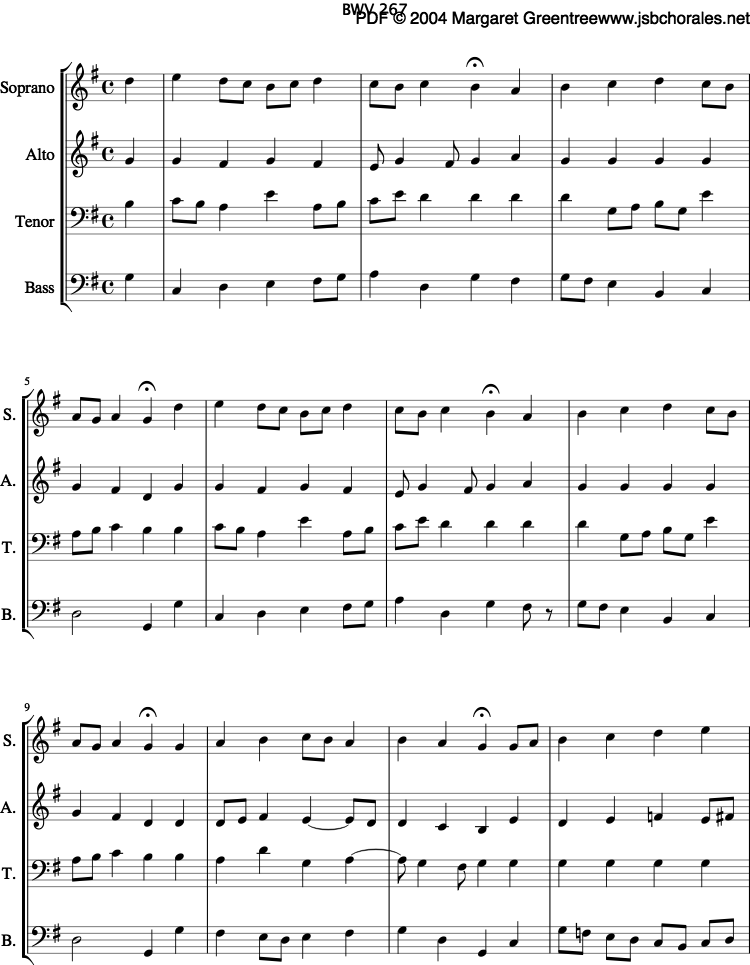

In [15]:
# this is what the original score looked like for BWV 267
bach_dict['bwv267']['score'].show()

In [7]:
# use deepcopy to create a copy of the score. we will turn this into a score where
# all the notes have the same duration.

def make_score1_copy():
    
    for key in bach_dict.keys():
        bach_dict[key]['score1'] = copy.deepcopy(bach_dict[key]['score'])


In [8]:
make_score1_copy()

### figure out what the minimum duration is for all notes
most likely 16th notes. hopefuly nothing else smaller

In [11]:

def find_smallest_duration_of_score(key):    
    # set a smallest duration - we know there are quarter notes in all bach chorales
    smallest_duration = 1.0
    
    # find the score for this bwv key
    score = bach_dict[key]['score1']

    for note in score.recurse().notes:
        # iteratively go through and determine smallest duration by checking each note
        if note.quarterLength < smallest_duration:
            smallest_duration = note.quarterLength

    return smallest_duration

find_smallest_duration_of_score('bwv267')

0.25

In [12]:
def determine_smallest_duration_all_scores():
    smallest_duration = 1.0
    
    for key in bach_dict.keys():
        each_smallest_duration = find_smallest_duration_of_score(key)
        if each_smallest_duration == 0.125:
            print "This score has 32nd notes:", key
        
        if each_smallest_duration < smallest_duration:
            smallest_duration = each_smallest_duration
            
    return smallest_duration

determine_smallest_duration_all_scores()

This score has 32nd notes: bwv432


0.125

In [13]:
# crap. one of them has 32nd notes.

# OK - this score has 2 instances of 2 32nd notes that I can turn into 16th notes. 
# it is dotted eighth plus 2 32nd. i will make it 1 eighth + 2 16ths.

### once i have the minimum duration, take each note that isn't a 16th note and turn it into 16th notes

Special accommodations were needed for rests and for chords (some sort of mistake where two notes with the same pitch would occur simultaneously but therefore were Chord objects in music21 rather than Note objects).

In [22]:
################## TROUBLESHOOTING 2ND VERSION ##################
################## ADDING RESTS INTO THIS VERSION ##################
################## USE THIS VERSION IF IT WORKS ##################
# function to replace notes with 16th notes FOR A SINGLE MEASURE

def sub_16th_notes_in_single_measure_TS_rests(measure_var):
    for orig_note in measure_var.notesAndRests:
#         print orig_note.offset, orig_note, orig_note.quarterLength

        # if the element is a chord, turn it into a single note, then
        # keep it going through this process by replacing orig_note with 
        # this. this is becasue you may need to turn it into 16th notes
        if type(orig_note) == m21.chord.Chord:
            orig_note = turn_a_chord_into_note(measure_var, orig_note)
           
            
        # determine how many 16th notes i have to make to replace the note
        # then replace it
        if orig_note.quarterLength > 0.25:
            convert_into_16ths(measure_var, orig_note)

        if orig_note.quarterLength == 0.125:
            print "You need to look at this score and remove the 32nd notes."

    return measure_var

#############
# make a function that cleans up the scores with chords instead of 
# single notes

def turn_a_chord_into_note(measure_var, chord_var):
    # FIRST determine pitch
            
    # first set the pitch to be an empty list. we will add to 
    # it when we determine what the pitch is. hopefully it stays
    # length = 1
    chord_pitch_list = []

    # pitchNames returns the pitch names, will also return repeats
    # (not unique)
    # go through every note to make sure it is the same as all
    # other notes in the chord
    for each_note in chord_var:
        # if the pitch is the same as the one in the chord_pitch,
        # then go on to the next pitch
        if each_note.pitch in chord_pitch_list:
            continue
        chord_pitch_list.append(each_note.pitch)


    # cehck length is 1
    if len(chord_pitch_list) > 1:
        print "troubleshoot needed - chord has more than one pitch"

    if len(chord_pitch_list) < 1:
        print "troubleshoot needed - chord has LESS than one pitch?"
        
    chord_pitch = chord_pitch_list[0]


    # determine duration
    chord_dur = chord_var.duration
    
    # determine offset
    location = chord_var.offset

    # make a new Note and make it orig_note
    orig_note = m21.note.Note(chord_pitch)
    orig_note.duration = chord_dur
    orig_note.offset = location

    # remove the original note
    measure_var.remove(chord_var)

    return orig_note

#############
# convert notes into 16ths

def convert_into_16ths(measure_var, note_var):
    n_sixteenths = note_var.quarterLength / 0.25

    # each 16th note is going to look like this:
    # depends on whether it is note or rest
    if type(note_var) == m21.note.Note:
        replacement_note_or_rest = m21.note.Note(note_var.name +
                                                 str(note_var.octave))
    if type(note_var) == m21.note.Rest:
        replacement_note_or_rest = m21.note.Rest()
    
    # duration is 16th notes
    replacement_note_or_rest.quarterLength = 0.25

    # set each 16th note! do it as many times as required (denoted by n_sixteenths)
    for nth_16th_note_increment in range(int(n_sixteenths)):
        # the first 16th note will be placed exactly at the orig_note's offset
        # the next ones will be offset by 16th note increments
        location = note_var.offset + nth_16th_note_increment * 0.25

        # insert a COPY of the replacement note at the location
        measure_var.insert(location, copy.deepcopy(replacement_note_or_rest))

    # remove the original note
    measure_var.remove(note_var)

### Since the previous function was at the measure level, create a function that allows me to apply a MEASURE-level function on a SCORE (which contains lots of measures)

Music21 has different hierarchies of objects. They all play well and nicely together but you have to know how to work with them.

In [26]:
# make a function to go through a score, identify the parts,
# and recurse a function on the measures of each part

def recurse_measure_level_function_on_score(score, function):
    """takes a function taht works on a MEASURE and makes it work on
    an overall stream/SCORE"""
    for score_element in score.elements:
        # do this on score elements that are PARTS
        if type(score_element) == m21.stream.Part:
            print 'yup this is part', score_element.partName

            # within a part, do this on part elements that are MEASURES
            for part_element in score_element.elements:
                if type(part_element) == m21.stream.Measure:
#                     print 'yup this is measure', part_element.measureNumber
                    function(part_element)


### Create SCORE1 for all scores in bach_dict. 
Do this by iteration across all scores for every key in the bach_dict.

In [28]:
# CREATE EVERY score1 - a score that is comprised completely of 
# 16th notes

def create_score1_bach_dict():
    # for every bach chorale in the keys
    for i, bach_key in enumerate(bach_dict.keys()):
        score = bach_dict[bach_key]['score1']
        score.id = bach_key
        print i, score.id
        
        recurse_measure_level_function_on_score(score,
                                               sub_16th_notes_in_single_measure_TS_rests)
    

In [29]:
# Do this AFTER creating score1 to fix score BWV432 which has 32nd notes.
def fix_bwv432_32nd_notes():
    bwv432 = bach_dict['bwv432']['score1']
    # the problem is only in the soprano part
    soprano_ = bwv432.parts[0]#.measure(11)#.show('text')
    
    # 1st measure
    ms1 = soprano_.measure(4)
    
    # adjust 1st measure, note 7
    note7 = ms1.notes[6]
    note7.pitch.name = 'F#4'

    # adjust 1st measure note 8
    note8 = ms1.notes[7]
    note8.pitch.name = 'G4'
    note8.quarterLength = 0.25

    # remove the last note
    ms1.remove(ms1.notes[8])
    
    # 2nd measure
    ms2 = soprano_.measure(6)
    
    # fix 2nd measure, 3rd note
    note3 = ms2.notes[2]
    note3.pitch.name = 'F#4'
    
    # fix 2nd m, 4th note
    note4 = ms2.notes[3]
    note4.pitch.name = 'G4'
    note4.quarterLength = 0.25
    
    # remove the last note
    ms2.remove(ms2.notes[4])

In [30]:
############## create score1 and fix bwv432
create_score1_bach_dict()
# HAS PROBLEMS WITH BWV377 - fixed, i think

fix_bwv432_32nd_notes()

0 bwv421
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is part Bass
1 bwv346
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is part Bass
2 bwv347
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is part Bass
3 bwv344
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is part Bass
4 bwv345
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is part Bass
5 bwv342
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is part Bass
6 bwv343
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is part Bass
7 bwv340
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is part Bass
8 bwv341
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is part Bass
9 bwv427
yup this is part Soprano
yup this is part Alto
yup this is part Tenor
yup this is 

#### Ta da!
You see this is what a score1 looks like.

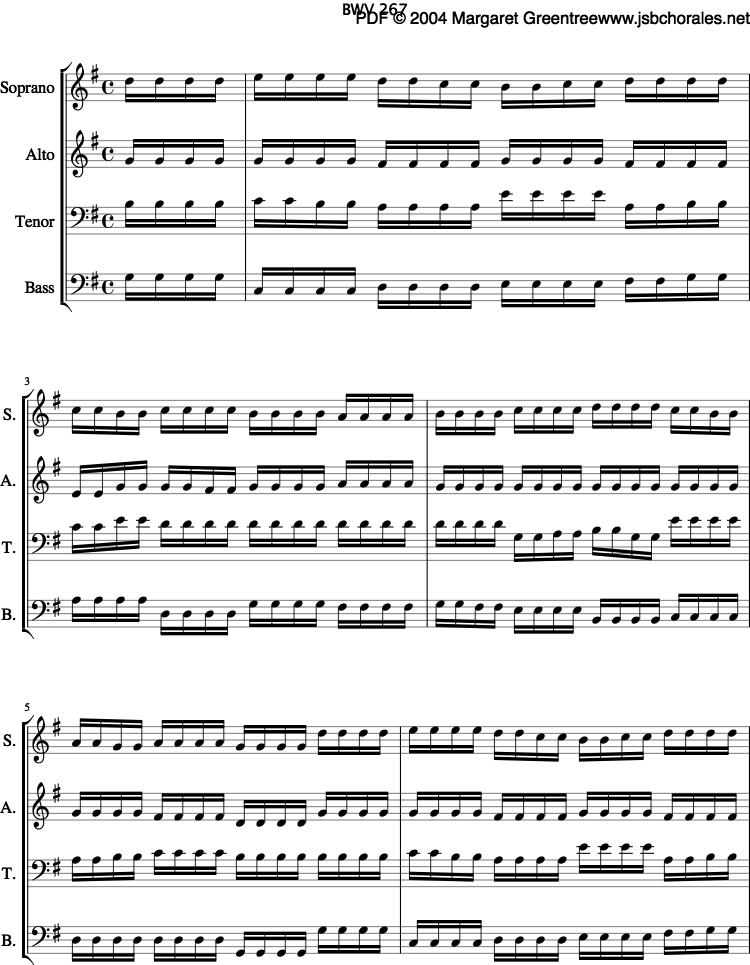

In [47]:
bach_dict['bwv267']['score1'].show()

![](../../capstone/presentation/yay_gifs/tinafey2.gif)
## Now that we have score1, we need score2.  
Score2 will be the same as score1, except that the scores will be transposed to the same key across the board. This makes it easier for the model to run on categorical values - if you are in the key of G major or G minor, then the pitch G (as the "tonic" or starting note of a G scale) has much more importance than if we were in the key of D major (where G is the 4th note in the scale).

### -------Cecilia to add a data viz histogram here that shows the frequency of occurrence of G and other notes -------


### -------Cecilia to add a data viz histogram here that shows the different original keys of the scores -------


In [31]:
# use deepcopy to create a copy of the score. we will turn this into
# a score where all the notes have the same key.

def make_score2_copy():
    for key in bach_dict.keys():
        bach_dict[key]['score2'] = copy.deepcopy(bach_dict[key]['score1'])

In [32]:
def transpose_score_to_G():
    for score_key in bach_dict.keys():
        score2 = bach_dict[score_key]['score2']
        
        # save the original key 
        # use the music21 specified algorithm
        orig_key = score2.analyze('key')
        bach_dict[score_key]['orig_key'] = orig_key

        # store the correlation coefficient
        bach_dict[score_key]['key_corrcoef'] = orig_key.correlationCoefficient

        # define interval (diff between orig key and G)
        note_start = orig_key.getTonic()
        interval = m21.interval.Interval(noteStart=note_start, 
                      noteEnd=m21.note.Note('G4'))
        
        # transpose score2, inplace=True
        score2.transpose(interval, inPlace=True)

In [33]:
########### Create Score 2 - copy all scores
make_score2_copy()

In [34]:
############# and transpose all scores to to G
transpose_score_to_G()

#### let's run a check to make sure the length of all parts is the same

In [35]:
# function to check that for each score, the length of the parts 
# is the same
def check_parts_length():
    for i, score_key in enumerate(bach_dict.keys()):
        score2 = bach_dict[score_key]['score2']
        
        soprano_length = len(score2.parts[0].recurse().notesAndRests)
        print i, score_key, soprano_length
        alto_length = len(score2.parts[1].recurse().notesAndRests)
        tenor_length = len(score2.parts[2].recurse().notesAndRests)
        bass_length = len(score2.parts[3].recurse().notesAndRests)
        
        if alto_length != soprano_length:
            print score2, "alto part, length", alto_length, \
                "does not equal soprano part, length", soprano_length
        
        if tenor_length != soprano_length:
            print score2, "tenor part, length", tenor_length, \
                "does not equal soprano part, length", soprano_length
                
        if bass_length != bass_length:
                        print score2, "bass part, length", bass_length, \
                "does not equal soprano part, length", soprano_length
                
        bach_dict[score_key]['n_16th_increments'] = soprano_length

In [36]:
check_parts_length()

0 bwv421 160
1 bwv346 244
2 bwv347 272
3 bwv344 288
4 bwv345 256
5 bwv342 288
6 bwv343 348
7 bwv340 400
8 bwv341 144
9 bwv427 224
10 bwv426 256
11 bwv425 404
12 bwv424 208
13 bwv423 256
14 bwv422 208
15 bwv348 256
16 bwv349 192
17 bwv298 148
18 bwv299 288
19 bwv294 320
20 bwv295 192
21 bwv296 224
22 bwv297 180
23 bwv290 128
24 bwv291 176
25 bwv292 224
26 bwv293 128
27 bwv355 256
28 bwv354 256
29 bwv357 256
30 bwv356 336
31 bwv351 144
32 bwv350 288
33 bwv353 304
34 bwv352 256
35 bwv359 256
36 bwv358 304
37 bwv289 192
38 bwv288 192
39 bwv283 272
40 bwv282 228
41 bwv281 128
42 bwv280 288
43 bwv287 256
44 bwv286 96
45 bwv285 192
46 bwv284 240
47 bwv416 192
48 bwv417 256
49 bwv360 256
50 bwv361 208
51 bwv362 552
52 bwv363 192
53 bwv364 176
54 bwv365 224
55 bwv366 288
56 bwv367 192
57 bwv368 388
58 bwv369 256
59 bwv413 480
60 bwv410 224
61 bwv411 272
62 bwv258 224
63 bwv310 160
64 bwv420 160
65 bwv276 472
66 bwv277 260
67 bwv272 256
68 bwv273 160
69 bwv270 256
70 bwv271 256
71 bwv377 192
72 

![](../../capstone/presentation/yay_gifs/hotkatemckinnon.gif)
## now that I have score2, I need to turn the music into a dataframe.

I also want to collect other data that we can use as features. In music, the position of a note in the entire composition as well as in a measure has importance. Each note is always "doing something" - whether starting a phrase, moving it along, or ending it. Each note also has a place in the piece's harmonic journey, and Bach certainly followed a pattern, usually starting in the "overall key", then traveling to different harmonies in the middle, and finally returning, usually, back to the original "overall key". 

Because of this, I wanted to track how far the note was from the beginning of the piece and the end of the piece. I also tracked how far the note was from the beginning of a *measure* and the end of a measure. Then, since the position of each quarter in a measure also has meaning, I tracked the note's "beat" or "quarter" position in a measure.

In [37]:
# create a list that indicates, for every note, which NOTE position it holds in each measure

# function input = measure number
# function output = tells you what position that note is in the meausre
# looks like [1,2,3,4,5,6,..,1,2,3,4,..,1,2,3,4,5,5,..etc]
def create_note_in_measure_position(x):
    current_measure = -1
    count = 0
    
    in_measure_note_position = []
    
    for element in x:
        if element != current_measure:
            current_measure = element
            count = 1

        else: 
            count += 1
        
        in_measure_note_position.append(count)            
    
    return in_measure_note_position


# test_df['in_measure_quarter_position'] = 

In [38]:

# input is note_in_measure_position LIST
# output is quarter_in_measure_position

def create_quarter_in_measure_position(note_in_measure_position_list, time_sig_numerator):
    # set this so that the function skips the first measure
    trip_wire = -1
    quarter_count = 0
    
    return_list = []
    ########## SET POSITION FOR ALL BUT FIRST MEASURE ##########
    # for every note in in_measure_note_position
    for every_note in note_in_measure_position_list:
        # wait for 2nd measure (measure[1]) since the first one
        # may not have notes for the full measure
        # every time x is 1, add 1 to trip_wire
        # -1 means that no rows/xs have been looked at yet
        # 0 means that the first note of measure 0 has passed
        # 1 means measure 1 has started
        # only do something after trip_wire becomes 1
        # also, trip_wire is same as measure #
        if every_note == 1:
            trip_wire += 1
        
        # only when the trip wire is >= 1, start doing this:
        if trip_wire >= 1:
            # if pos = 1: 
            if every_note == 1:
                # set quarter_count = 1
                quarter_count = 1
                # append quarter_count to return_list
                return_list.append(quarter_count)
            
            # if pos % 4 = 0:
            # every fourth note should be the LAST one before the
            # quarter_count changes
            elif every_note % 4 == 0:
                # append quarter_count to return_list
                return_list.append(quarter_count)
                # set quarter_count += 1
                quarter_count += 1
            
            # for all other numbers, just append
            else:
                # append quarter_count to return_list
                return_list.append(quarter_count)

#     print 'return_list: ', return_list
    
    ########## SET POSITION FOR FIRST MEASURE ##########        
    # then do the first measure so that the correct 'beats' relative
    # to the time signature are assigned 
    # ie if the first measure is only 4 16th notes, or one quarter, and time
    # signature is 3/4, then the four 16th notes shoudl be labeled "3"
    # instead of 1
    
    # np.where returns a tuple (array, ) where the array indicates the 
    # locations within x.values where it is 1.
    # need to do [0] to get the array from teh tuple, then doing [1]
    # returns the SECOND time the first note of a measure shows up. 
    # in other words, the index of when second measure begins
    # using np.where only because i wrote thsi initially for an array
    start_measure_2 = np.where(np.array(note_in_measure_position_list)==1)[0][1]
    
    # the first measure goes from the begining until the start of 
    # meausre 2. 
    first_measure_array = note_in_measure_position_list[0:start_measure_2]
    
    # determine the number of quarters in measure 1
    number_quarters_measure_1 = len(first_measure_array) / 4

    # based on number of quarters in m1 and the time signature, this
    # is a calculation of the FIRST possible quarter 'beat' for the meausre.
    # ie. if number of quarters = 2 and the time signature is 4/4, then
    # the the first quarter is '3' and the second quarter is '4'. 
    m1_first_quarter = time_sig_numerator - number_quarters_measure_1 + 1
    
    # Set quarter_count to be the first possible quarter note for the 1st measure
    quarter_count = m1_first_quarter
    
    # create list for first measure
    m1_return_list = []
    
    for every_note in first_measure_array:
        # if pos % 4 = 0:
        # every fourth note should be the LAST one before the
        # quarter_count changes
        if every_note % 4 == 0:
            # append quarter_count to return_list
            m1_return_list.append(quarter_count)
            # set quarter_count += 1
            quarter_count += 1

        # for all other numbers, just append
        else:
            # append quarter_count to return_list
            m1_return_list.append(quarter_count)
            
#     print 'm1return_list: ', m1_return_list
        
    m1_return_list.extend(return_list)
    
#     print 'final return list',  m1_return_list
    return m1_return_list

In [39]:
# takes score2, pulls all notes for each part, and creates a DF with 
# one column for each part. each row is a subsequent 16th note increment
# also including the original key in there

def create_bach_df():
    # create an empty dataframe
    bach_df = pd.DataFrame()
    
    # for each of the scores
    for score_key in bach_dict.keys():
        score2 = bach_dict[score_key]['score2']
        
        # pull all the notes and rests from each of the parts
        soprano = list(score2.parts[0].recurse().notesAndRests)
        alto = list(score2.parts[1].recurse().notesAndRests)
        tenor = list(score2.parts[2].recurse().notesAndRests)
        bass = list(score2.parts[3].recurse().notesAndRests)
        
        # time signature
        time_signature = score2.recurse().getElementsByClass(
                            m21.meter.TimeSignature)[0]
        beats_per_measure = time_signature.numerator
        
        # create a 'forward' count of notes, starting from 0
        forward_note = np.arange(len(soprano))
        
        # create a 'backward' count of notes, with 0 being the last note
        back_note = [len(soprano) - x - 1 for x in range(len(soprano))]
        
        # create measure numbers by grabbing the measure number for each
        # of the notes/rests in the soprano list, starting from 0
        forward_measure = [element.measureNumber for element in soprano]
        
        # create a 'backward' count of measures (like a measure countdown
        # until the end). last measure is 0.
        # need to create a total # of measures using max(forward_measure)
        n_measures = np.max(forward_measure)
        back_measure = [n_measures - x for x in forward_measure]
        
        # each note's position in its measure
        note_in_measure_position = create_note_in_measure_position(forward_measure)
        
        # each note's "beat" or "quarter" in its measure
        quarter_in_measure_position = create_quarter_in_measure_position(
            note_in_measure_position, beats_per_measure)
        
        # create temp df
        temp_df = pd.DataFrame({'BWV'    : score_key,
                        'orig_key'  : bach_dict[score_key]['orig_key'],
                        'beats_per_measure' : beats_per_measure,
                        'forward_note'   : forward_note,
                        'back_note'      : back_note,      
                        'forward_measure': forward_measure,
                        'back_measure'   : back_measure, 
                        "note_in_measure_position" : note_in_measure_position,
                        'quarter_in_measure_position' : quarter_in_measure_position,
                        'soprano'        : soprano,
                        'alto'           : alto,
                        'tenor'          : tenor,
                        'bass'           : bass
                               },
                        columns=['BWV','orig_key', 'beats_per_measure',
                                 'forward_note', 'back_note', 
                                 'forward_measure', 'back_measure', 
                                 "note_in_measure_position", 'quarter_in_measure_position',
                                 'soprano', 'alto', 'tenor', 'bass'],
                        index=[score_key + '_' + str(x) 
                               for x in range(len(soprano))]
                              )
        
        bach_df = pd.concat([bach_df, temp_df], axis=0)
        
    return bach_df

In [40]:
################### create the df ##############
bach_df = create_bach_df()
# trouble with score 281-fixed

In [41]:
f = open('bach.p', 'wb')
cPickle.dump(bach_df, f)
f.close()

![](../../capstone/presentation/yay_gifs/hotkatemckinnon.gif)
![](../presentation/yay_gifs/belcher.gif)


----------------
### Please continue on to the second page of the technical report, avaialble in the github.